In [251]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.impute import SimpleImputer
from datetime import timedelta

north_data = pd.read_csv('./weather-csv/north_weekly_averages.csv')
south_data = pd.read_csv('./weather-csv/south_weekly_averages.csv')
central_data = pd.read_csv('./weather-csv/central_weekly_averages.csv')
east_data = pd.read_csv('./weather-csv/east_weekly_averages.csv')
fuel_prices = pd.read_csv('./fuel_prices.csv')
cabbage_prices = pd.read_csv('./vegetable-csv/Domestic_Cabbage.csv')
chinese_cabbage_prices = pd.read_csv('./vegetable-csv/Domestic_Chinese_cabbage.csv')
cauliflower_prices = pd.read_csv('./vegetable-csv/Domestic_Cauliflower.csv')



# 資料前處理
## 天氣特徵資料
- 將各地天氣特徵值欄位加入地區資訊
- 檢查各地天氣資料缺失值：使用前一周的資料來填充缺失值
- 合併4個區域天氣資訊
## 蔬菜特徵資料
- 修改欄位名稱：每個欄位名稱都加上蔬菜種類
- 檢查4種蔬菜資料缺失值 : 無
- 合併3種蔬菜資料
- 檢查合併資料重複值 : 無
## 汽油與柴油價格
- 檢查原始檔案缺失值
- 刪除日期不是從星期一的資料
## 合併後的資料集
- 對於天氣欄位採用前一週數據來填充
- 對於蔬菜、汽油柴油相關欄位，採用平均值來填充

In [252]:
# 檢查缺失值
def check_missing_values(df, name):
    missing = df.isnull().sum()
    missing_df = pd.DataFrame({"Missing Count": missing})
    missing_df = missing_df[missing_df["Missing Count"] > 0]
    if missing_df.empty:
        print(f"缺失值統計（{name}）： None")
        return pd.DataFrame()  # 返回空的 DataFrame
    else:
        all_missing_data = []
        for col in missing_df.index:
            print(f"\n缺失值所在的列：{col}")
            missing_data = df[df[col].isnull()][["date", col]] 
            print(missing_data)
            all_missing_data.append(missing_data)
        all_missing_df = pd.concat(all_missing_data) if all_missing_data else pd.DataFrame()
        print(all_missing_df.head())


In [253]:
# 使用前一周的數據填充缺失值
def fill_missing_with_previous_week(df):
    filled_df = df.copy()
    filled_df = filled_df.sort_values(by='date')  # 確保按照日期排序
    filled_df.fillna(method='ffill', inplace=True)  # 使用前向填充
    return filled_df

In [254]:
# 合併4大地區天氣
# 修改各地區天氣資料欄位名稱
north_data.columns = [f"north_{col}" if col != "週" else "週" for col in north_data.columns]
south_data.columns = [f"south_{col}" if col != "週" else "週" for col in south_data.columns]
central_data.columns = [f"central_{col}" if col != "週" else "週" for col in central_data.columns]
east_data.columns = [f"east_{col}" if col != "週" else "週" for col in east_data.columns]

check_missing_values(north_data, "North Data")
check_missing_values(south_data, "South Data")
check_missing_values(central_data, "Central Data")
check_missing_values(east_data, "East Data")

缺失值統計（North Data）： None
缺失值統計（South Data）： None
缺失值統計（Central Data）： None
缺失值統計（East Data）： None


Empty DataFrame
Columns: []
Index: []

In [255]:
# 合併各地區的天氣資料為單一 DataFrame
regional_data_1 = pd.merge(
    north_data,
    south_data,
    on='週',
    how='outer'
).merge(
    central_data,
    on='週',
    how='outer'
).merge(
    east_data,
    on='週',
    how='outer'
).rename(columns={"週": "date"})

regional_data_1 = regional_data_1.rename(columns={"週" : "date"})
check_missing_values(regional_data_1, "weather data")

# 填充缺失值
regional_data_1 = fill_missing_with_previous_week(regional_data_1)

print("After deal with the empty value")
check_missing_values(regional_data_1, "weather data")


缺失值所在的列：south_平均氣壓(hPa)
                    date  south_平均氣壓(hPa)
5  2019-02-04/2019-02-10              NaN

缺失值所在的列：south_平均氣溫(℃)
                    date  south_平均氣溫(℃)
5  2019-02-04/2019-02-10            NaN

缺失值所在的列：south_平均相對溼度( %)
                    date  south_平均相對溼度( %)
5  2019-02-04/2019-02-10               NaN

缺失值所在的列：south_平均風速(m/s)
                    date  south_平均風速(m/s)
5  2019-02-04/2019-02-10              NaN

缺失值所在的列：south_累計雨量(mm)
                    date  south_累計雨量(mm)
5  2019-02-04/2019-02-10             NaN

缺失值所在的列：south_累積日射量(MJ/m2)
                    date  south_累積日射量(MJ/m2)
5  2019-02-04/2019-02-10                 NaN

缺失值所在的列：east_平均氣壓(hPa)
                     date  east_平均氣壓(hPa)
51  2019-12-23/2019-12-29             NaN

缺失值所在的列：east_平均氣溫(℃)
                     date  east_平均氣溫(℃)
51  2019-12-23/2019-12-29           NaN

缺失值所在的列：east_平均相對溼度( %)
                     date  east_平均相對溼度( %)
51  2019-12-23/2019-12-29              NaN

缺失值所在的列：east_平均風速(m/s

C:\Users\e4408\AppData\Local\Temp\ipykernel_27396\2134533310.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_df.fillna(method='ffill', inplace=True)  # 使用前向填充


Empty DataFrame
Columns: []
Index: []

In [256]:
print(regional_data_1.head())

# 檢查重複值
duplicates = regional_data_1[regional_data_1.duplicated(subset=['date'], keep=False)]
if duplicates.empty: print("No duplicate values")
else: print(duplicates)

                    date  north_平均氣壓(hPa)  north_平均氣溫(℃)  north_平均相對溼度( %)  \
0  2018-12-31/2019-01-06          1019.18          17.33             95.67   
1  2019-01-07/2019-01-13          1016.19          18.63             93.14   
2  2019-01-14/2019-01-20          1016.24          16.81             85.43   
3  2019-01-21/2019-01-27          1018.21          14.94             72.86   
4  2019-01-28/2019-02-03          1016.41          16.44             84.43   

   north_平均風速(m/s)  north_累計雨量(mm)  north_累積日射量(MJ/m2)  south_平均氣壓(hPa)  \
0             3.53            2.50                6.57          1019.90   
1             2.61            0.00                7.28          1016.39   
2             3.41            3.93                9.18          1016.59   
3             3.49            0.14               12.07          1017.86   
4             2.09            0.36               14.28          1017.10   

   south_平均氣溫(℃)  south_平均相對溼度( %)  ...  central_平均相對溼度( %)  \
0          19.53 

In [257]:
# 標準化欄位名稱
cabbage_prices.columns = ['date', 'cabbage_平均價', 'cabbage_交易量']
chinese_cabbage_prices.columns = ['date', 'chinese_cabbage_平均價', 'chinese_cabbage_交易量']
cauliflower_prices.columns = ['date', 'cauliflower_平均價', 'caulifower_交易量']

check_missing_values(cabbage_prices, "cabbage")
check_missing_values(chinese_cabbage_prices, "chinese cabbage")
check_missing_values(cauliflower_prices, "cauliflower")


缺失值統計（cabbage）： None
缺失值統計（chinese cabbage）： None
缺失值統計（cauliflower）： None


Empty DataFrame
Columns: []
Index: []

In [231]:
# 合併資料集
merged_vegetable_prices = pd.merge(
    cabbage_prices, 
    cauliflower_prices, 
    on='date', 
    how='outer'
).merge(
    chinese_cabbage_prices, 
    on='date', 
    how='outer'
)

print(merged_vegetable_prices.head())

# 檢查重複值
duplicates = merged_vegetable_prices[merged_vegetable_prices.duplicated(subset=['date'], keep=False)]
print("重複的記錄：")
print(duplicates)



                    date  cabbage_平均價  cabbage_交易量  cauliflower_平均價  \
0  2018-12-24/2018-12-30        26.60      3353.00              NaN   
1  2018-12-31/2019-01-06        22.22      4487.67            28.55   
2  2019-01-07/2019-01-13        20.40      4323.00            22.72   
3  2019-01-14/2019-01-20        19.78      5407.17            24.18   
4  2019-01-21/2019-01-27        20.47      6189.67            25.97   

   caulifower_交易量  chinese_cabbage_平均價  chinese_cabbage_交易量  
0             NaN                  NaN                  NaN  
1        39549.00                15.85              7315.50  
2        53975.33                10.63              7901.33  
3        37783.67                11.80              6472.67  
4        46511.33                14.42              7419.83  
重複的記錄：
Empty DataFrame
Columns: [date, cabbage_平均價, cabbage_交易量, cauliflower_平均價, caulifower_交易量, chinese_cabbage_平均價, chinese_cabbage_交易量]
Index: []


In [258]:
# 讀取油價數據並過濾非週一的記錄
fuel_prices['Date'] = pd.to_datetime(fuel_prices['Date'], format='%Y/%m/%d')
fuel_prices['Day_of_Week'] = fuel_prices['Date'].dt.dayofweek  # 獲取星期幾（0 表示週一）

# 過濾只保留週一的數據
filtered_fuel_prices = fuel_prices[fuel_prices['Day_of_Week'] == 0].drop(columns=['Day_of_Week'])


# 建立新表格，填入時間範圍
expanded_rows = []
for _, row in filtered_fuel_prices.iterrows():
    start_date = row['Date']  # 當前日期
    end_date = start_date + timedelta(days=6)  # 往後延展七天的範圍
    date_range = f"{start_date.strftime('%Y-%m-%d')}/{end_date.strftime('%Y-%m-%d')}"  # 生成日期範圍字串
    
    expanded_rows.append({
        'date': date_range,  # 使用日期範圍
        'Fuel_92': row['Fuel_92'],
        'Fuel_95': row['Fuel_95'],
        'Fuel_High': row['Fuel_High']
    })

# 將結果轉為新的 DataFrame
expanded_fuel_prices = pd.DataFrame(expanded_rows)

check_missing_values(expanded_fuel_prices, "fuel prices")

print(expanded_fuel_prices.head())


缺失值統計（fuel prices）： None
                    date  Fuel_92  Fuel_95  Fuel_High
0  2024-11-25/2024-12-01     28.6     30.1       27.2
1  2024-11-18/2024-11-24     28.6     30.1       27.1
2  2024-11-11/2024-11-17     28.4     29.9       26.8
3  2024-11-04/2024-11-10     28.8     30.3       27.2
4  2024-10-28/2024-11-03     28.6     30.1       27.0


In [259]:
# 合併天氣數據與油價數據
weather_fuel_data = pd.merge(
    regional_data_1,
    expanded_fuel_prices,
    on='date',
    how='outer'
)

# 合併天氣與油價的結果再與蔬菜價格數據合併
complete_data = pd.merge(
    weather_fuel_data,
    merged_vegetable_prices,
    on='date',
    how='outer'
)

# 將日期範圍解析為起始日期
complete_data['start_date'] = complete_data['date'].str.split('/').str[0]
complete_data['start_date'] = pd.to_datetime(complete_data['start_date'], errors='coerce')

# 篩選出 2019 至 2022 年的數據
complete_data = complete_data.dropna(subset=['start_date'])  # 去掉無效日期
complete_data = complete_data[(complete_data['start_date'] >= pd.Timestamp('2019-01-01')) & (complete_data['start_date'] <= pd.Timestamp('2022-12-31'))]


# 刪除掉start_date欄位
if 'start_date' in complete_data.columns:
    complete_data = complete_data.drop(columns=['start_date'])

check_missing_values(complete_data, "complete data")

# 檢視合併後的完整數據
# print(complete_data.head())



缺失值所在的列：Fuel_92
                      date  Fuel_92
5    2019-01-28/2019-02-03      NaN
6    2019-02-04/2019-02-10      NaN
7    2019-02-11/2019-02-17      NaN
9    2019-02-25/2019-03-03      NaN
10   2019-03-04/2019-03-10      NaN
11   2019-03-11/2019-03-17      NaN
32   2019-08-05/2019-08-11      NaN
34   2019-08-19/2019-08-25      NaN
45   2019-11-04/2019-11-10      NaN
54   2020-01-06/2020-01-12      NaN
60   2020-02-17/2020-02-23      NaN
81   2020-07-13/2020-07-19      NaN
82   2020-07-20/2020-07-26      NaN
83   2020-07-27/2020-08-02      NaN
85   2020-08-10/2020-08-16      NaN
86   2020-08-17/2020-08-23      NaN
87   2020-08-24/2020-08-30      NaN
88   2020-08-31/2020-09-06      NaN
89   2020-09-07/2020-09-13      NaN
92   2020-09-28/2020-10-04      NaN
94   2020-10-12/2020-10-18      NaN
95   2020-10-19/2020-10-25      NaN
96   2020-10-26/2020-11-01      NaN
100  2020-11-23/2020-11-29      NaN
109  2021-01-25/2021-01-31      NaN
111  2021-02-08/2021-02-14      NaN
112  2021-0

In [261]:
# 針對油價數據的缺失值，使用均值填充
fuel_columns = ['Fuel_92', 'Fuel_95', 'Fuel_High']
for col in fuel_columns:
    if col in complete_data.columns:
        complete_data[col] = complete_data[col].fillna(complete_data[col].mean())

# 針對蔬菜數據的缺失值，使用均值填充
vegetable_columns = ['cabbage_平均價', 'cabbage_交易量', 'cauliflower_平均價', 'caulifower_交易量', 
                     'chinese_cabbage_平均價', 'chinese_cabbage_交易量']
for col in vegetable_columns:
    if col in complete_data.columns:
        complete_data[col] = complete_data[col].fillna(complete_data[col].mean())

# 針對天氣數據的缺失值，使用上一週的數據填充
weather_columns = [col for col in complete_data.columns if col.startswith(('north_', 'south_', 'central_', 'east_'))]
for col in weather_columns:
    if col in complete_data.columns:
        complete_data[col] = complete_data[col].ffill()

check_missing_values(complete_data, "After cleaning complete data")
complete_data.to_csv("./All_X_Y.csv", index=False)


缺失值統計（After cleaning complete data）： None


## 切分訓練資料集以及測試資料集
- 切分比例 : 8:2

In [263]:
# 切分訓練集與測試集
complete_data = pd.read_csv("All_X_Y.csv")


# 預測目標欄位
vegetable_target_columns = ['cabbage_平均價', 'cauliflower_平均價', 'chinese_cabbage_平均價']


# 調整欄位順序，將目標欄位移動至最後
reordered_columns = [col for col in complete_data.columns if col not in vegetable_target_columns] + vegetable_target_columns
complete_data = complete_data[reordered_columns]

train_data, test_data = train_test_split(complete_data, test_size=0.2, random_state=42)


# 檢視訓練集與測試集資訊
def print_split_info(train, test):
    check_missing_values(train, "train data")
    check_missing_values(test, "test data")
    print(f"訓練集大小: {len(train)}")
    print(f"測試集大小: {len(test)}")

print_split_info(train_data, test_data)

# 將分割後的資料存成 CSV 文件
train_data.to_csv('./train.csv', index=False)
test_data.to_csv('./test.csv', index=False)

缺失值統計（train data）： None
缺失值統計（test data）： None
訓練集大小: 166
測試集大小: 42


# EDA
- 空缺值檢查
- 每個欄位的統計描述
- 每個欄位資料的分布圖
- 每個欄位之間的相關係數

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('All_X_Y.csv')

In [5]:
def plot_table_from_df(df):
    """
    使用 Matplotlib 繪製 DataFrame 表格。
    參數: df (pd.DataFrame): 需要繪製的 DataFrame。
    無回傳值，直接顯示圖表。
    """
    sns.set(style="white") # darkgrid, whitegrid, dark, white, ticks

    # 設定字體，選擇支援中文的字體
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 適用於 Windows
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

    plt.figure(figsize=(len(df.columns) * 1.2, len(df) * 0.2))

    # 建立 Matplotlib 表格
    ax = plt.gca()
    ax.axis('off')  # 隱藏軸
    ax.axis('tight')

    # 繪製表格
    table = plt.table(
        cellText=df.values,       # 表格內容
        colLabels=df.columns,     # 欄位名稱
        cellLoc='center',         # 文字置中
        loc='center'              # 表格位置置中
    )

    # 調整表格字體與大小
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # 調整畫布邊界
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # 顯示表格
    plt.show()

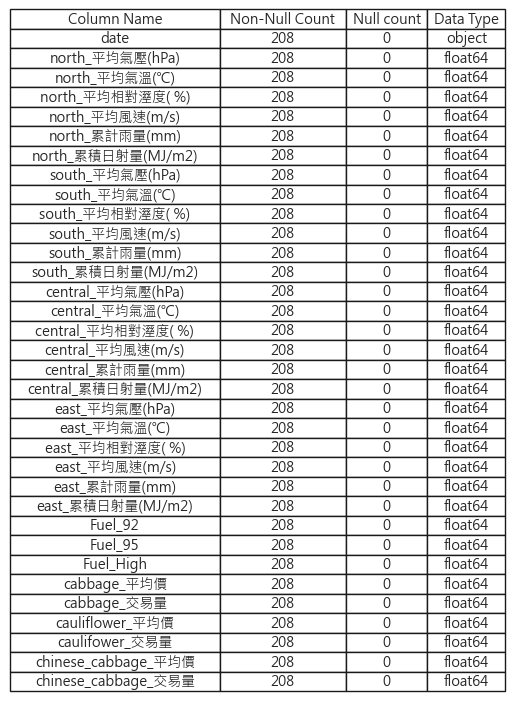

In [6]:
# 建立數據基本資訊的 DataFrame
info_df = pd.DataFrame({
    "Column Name": data.columns,
    "Non-Null Count": data.notnull().sum(),
    "Null count": data.isnull().sum(),
    "Data Type": data.dtypes
}).reset_index(drop=True)

# 呼叫函數繪製表格
plot_table_from_df(info_df)

In [9]:
def plot_describe_tables(data):
    """
    將每個欄位的 describe 結果繪製成獨立的表格，並顯示在同一張圖上。
    參數:data (pd.DataFrame): 要分析的 DataFrame。
    無回傳值，直接顯示圖表。
    """
    sns.set(style="white") # darkgrid, whitegrid, dark, white, ticks

    # 設定字體，選擇支援中文的字體
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 適用於 Windows
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

    # 取得數值型欄位的描述性統計結果
    num_cols = data.select_dtypes(include='number').columns
    
    # 設定畫布大小和子圖數量
    num_tables = len(num_cols)  # 欄位數量
    rows = (num_tables + 2) // 3  # 每行最多 3 個表格

    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 4))  # 畫布大小
    axes = axes.flatten()  # 將子圖陣列攤平成一維

    # 繪製每個欄位的描述性統計表格
    for i, col in enumerate(num_cols):
        # 取得欄位的描述性統計結果
        desc = data[col].describe().reset_index()
        desc.columns = ['Statistic', col]  # 重命名欄位

        # 在子圖中顯示表格
        axes[i].axis('off')  # 隱藏軸
        table = axes[i].table(
            cellText=desc.values,  # 表格內容
            colLabels=desc.columns,  # 欄位標題
            cellLoc='center',
            loc="center"
        )
        table.auto_set_font_size(False)  # 停用自動字體調整
        table.set_fontsize(12)  # 放大字體大小
        table.auto_set_column_width(col=list(range(len(desc.columns))))  # 自動調整欄寬
        axes[i].set_title(f"{col} 描述性統計", fontsize=16, pad=6)  # 設置標題，並縮小與表格的距離

        # 設置標題，縮小字體大小與間距
        axes[i].set_title(f"{col} 描述性統計", fontsize=14, pad=15)  # pad 縮短標題與表格間距

    # 移除多餘的子圖
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=1)
    plt.show()


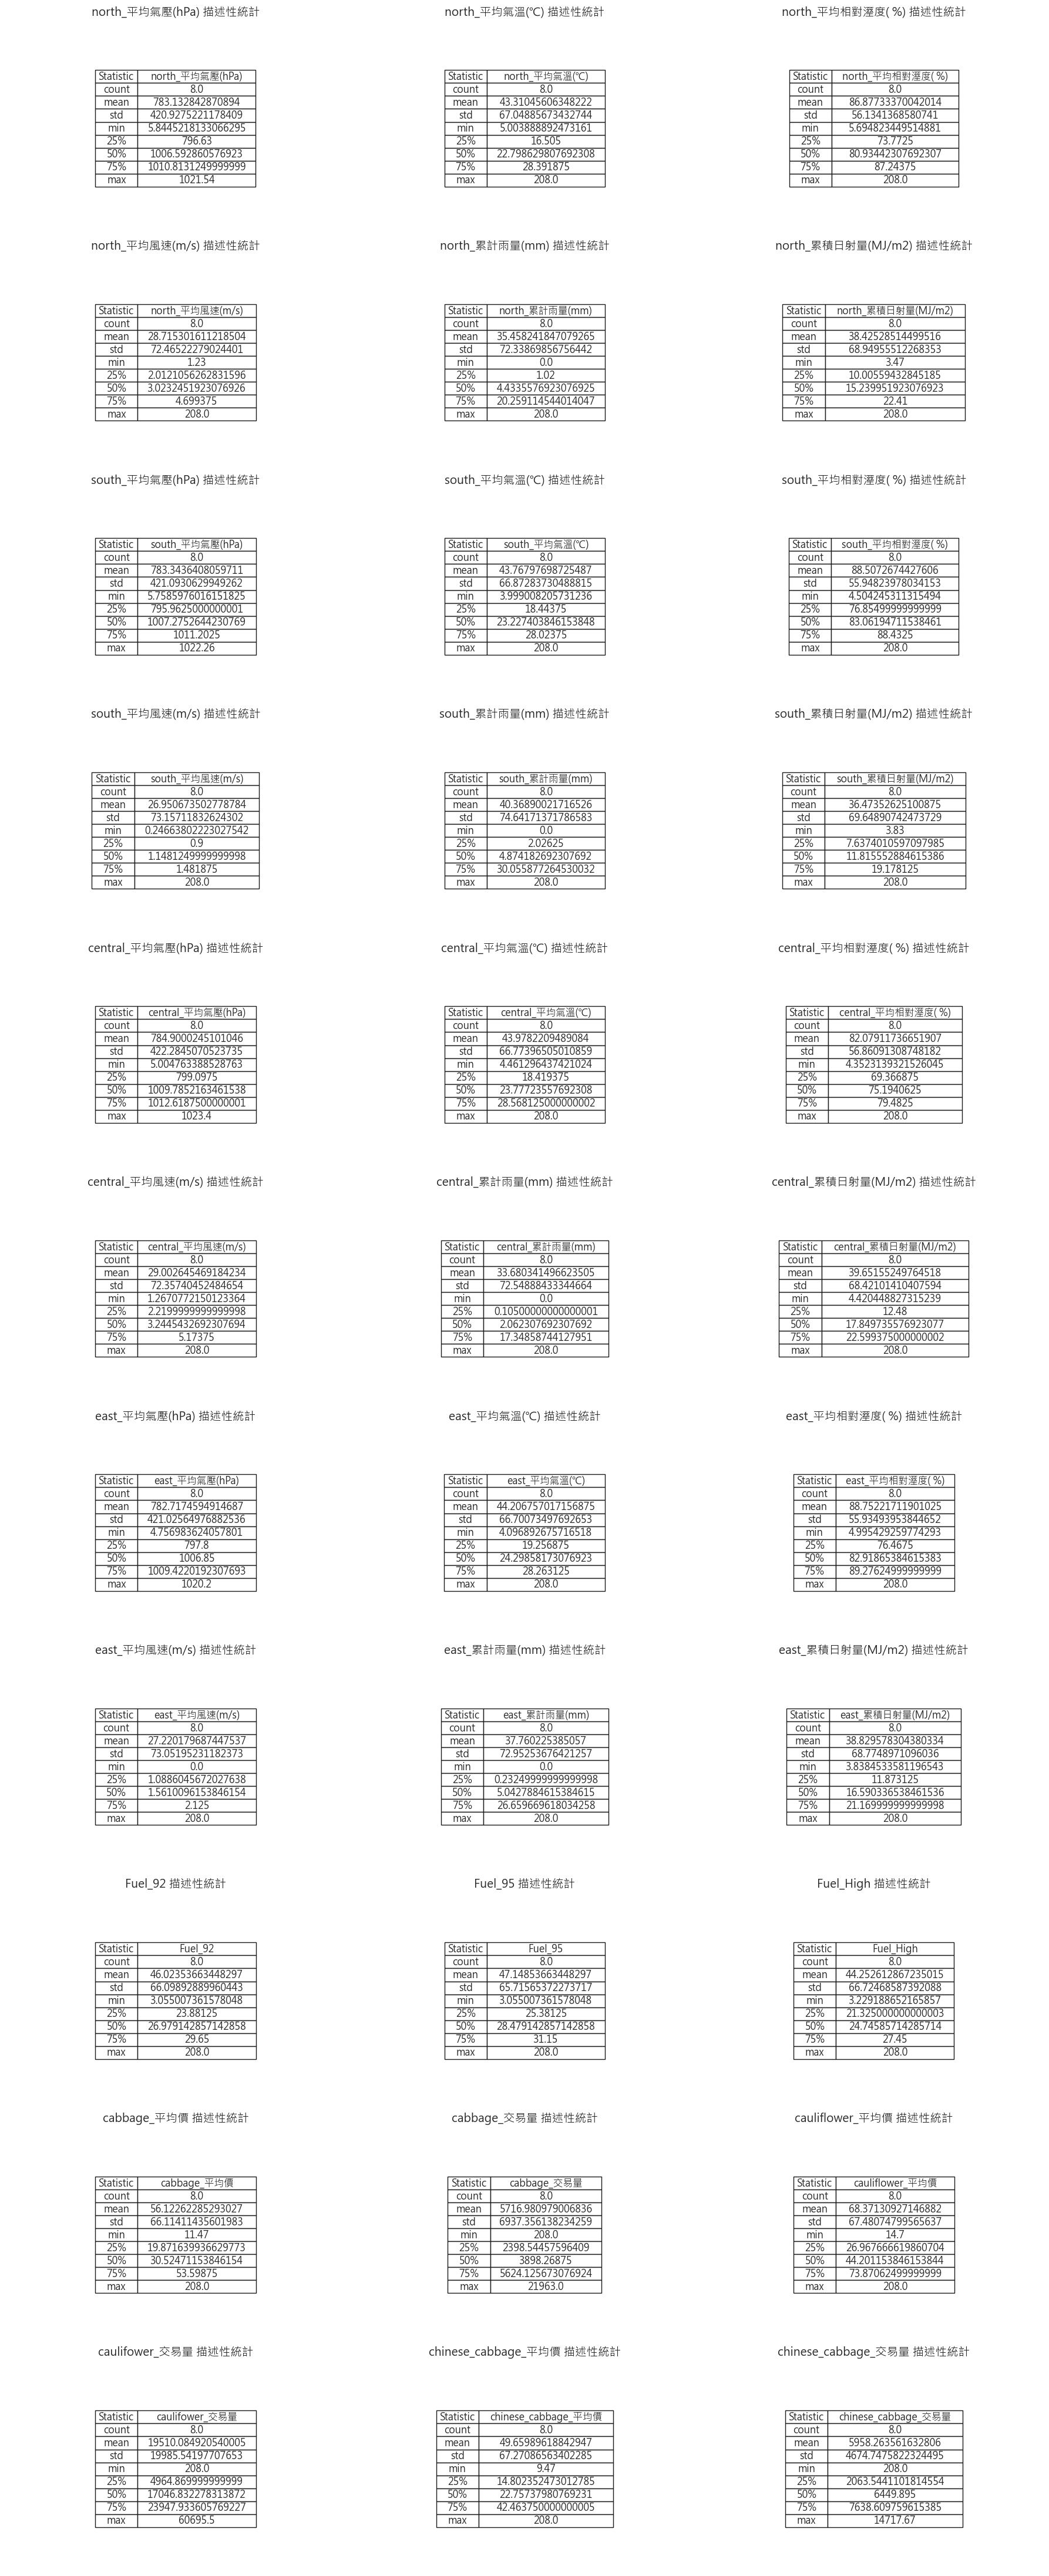

In [11]:
desc_df = data.describe()
plot_describe_tables(desc_df)

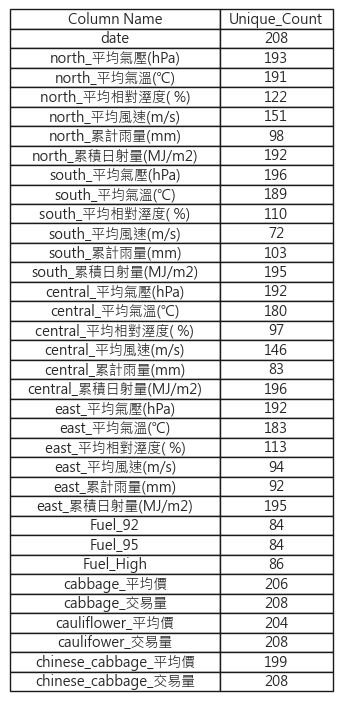

In [12]:
# 檢查數據分佈
unique_counts = data.nunique().reset_index()
unique_counts.columns = ['Column Name', 'Unique_Count']  # 重新命名欄位
unique_df = unique_counts

plot_table_from_df(unique_df)

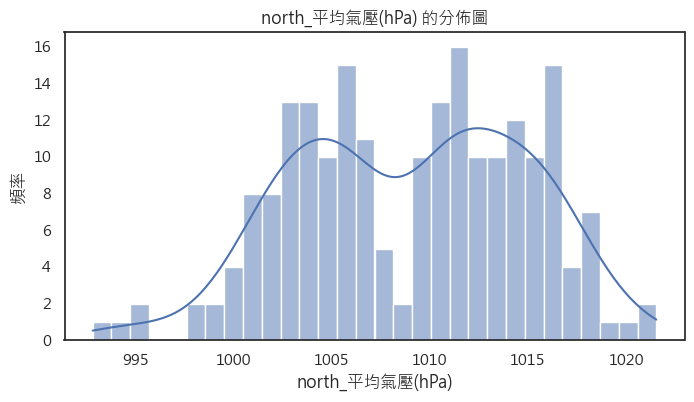

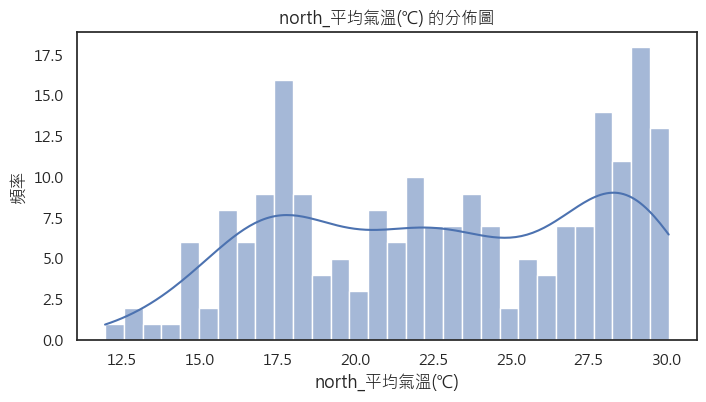

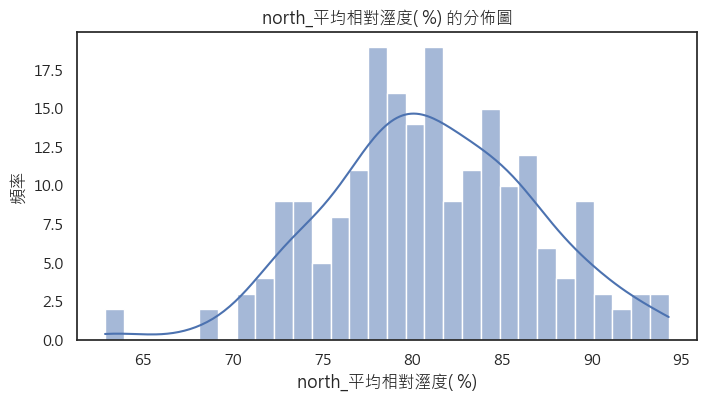

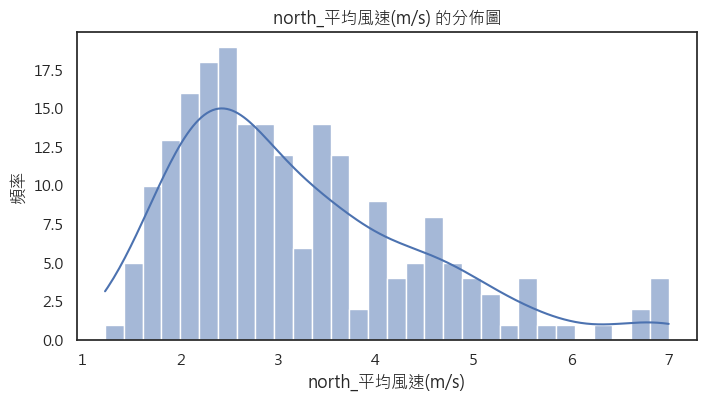

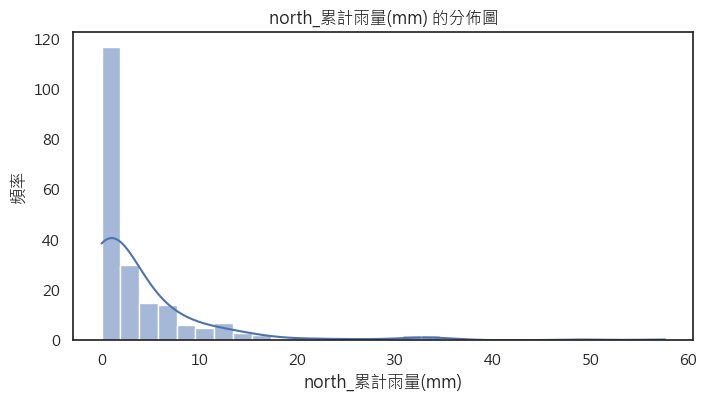

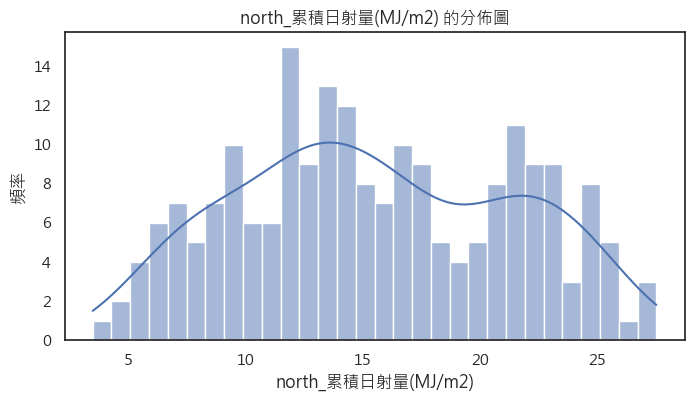

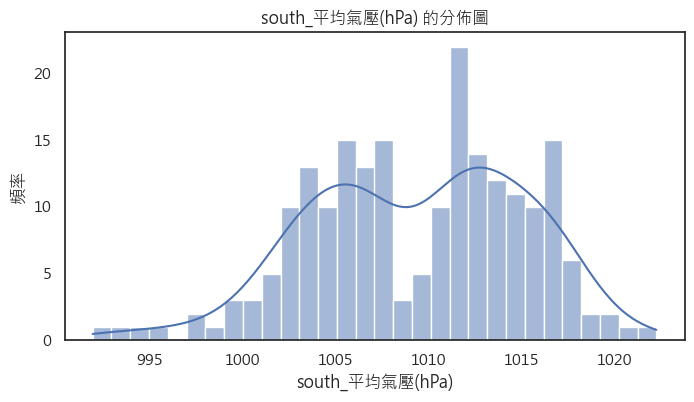

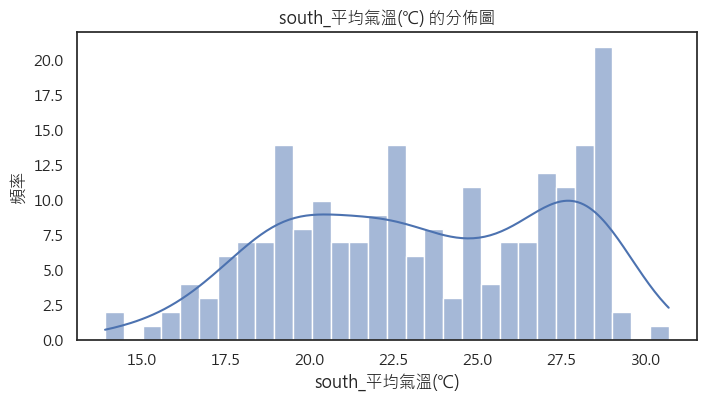

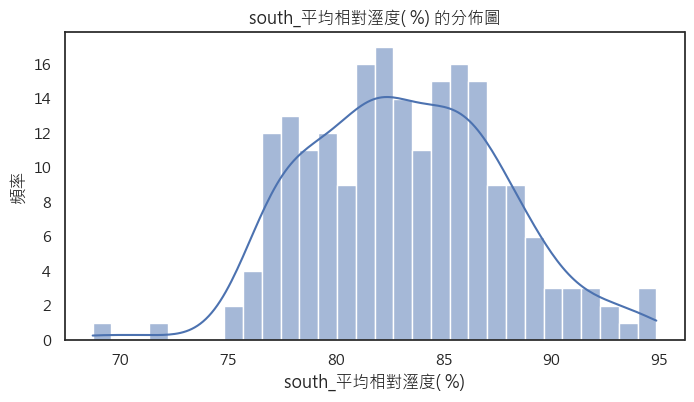

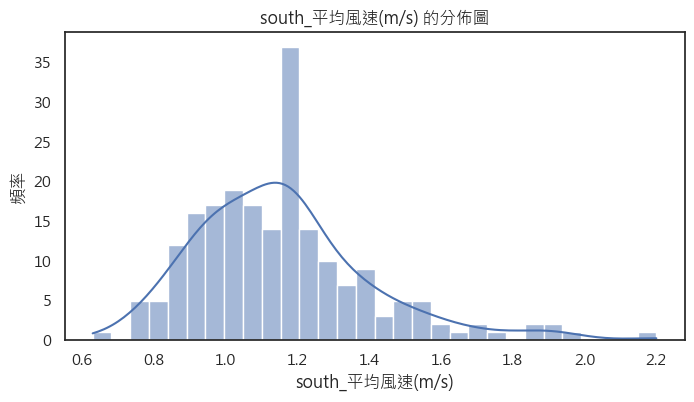

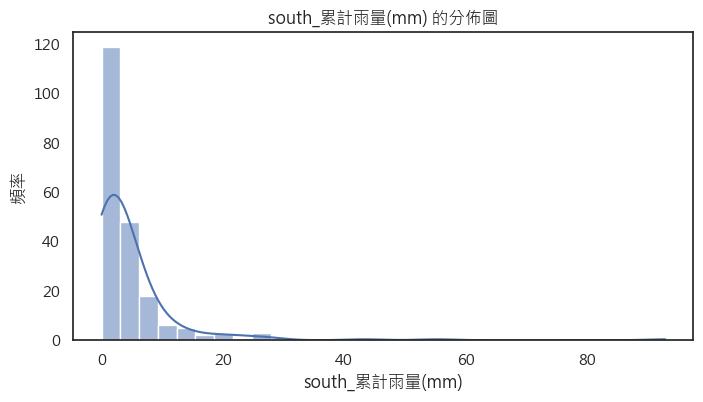

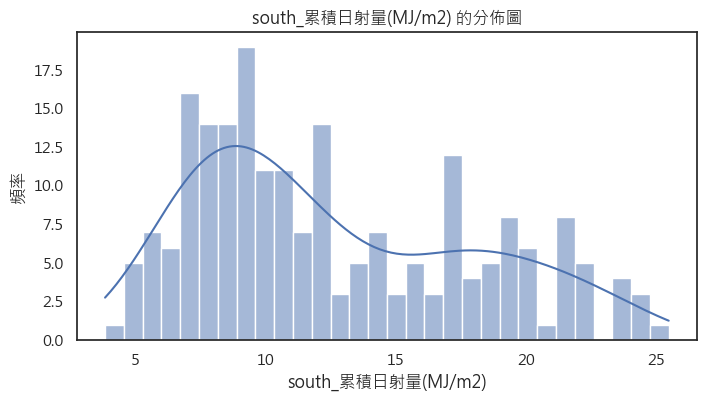

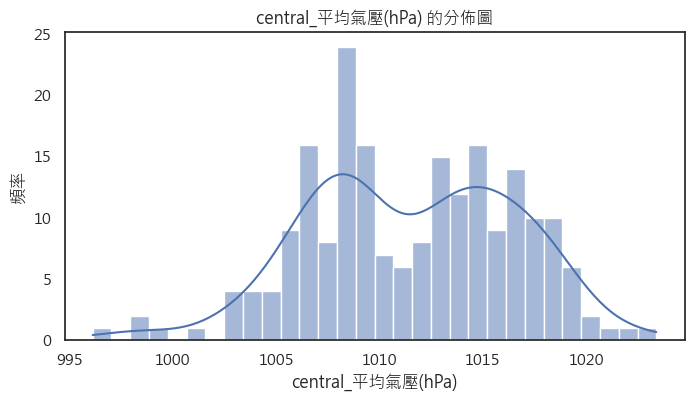

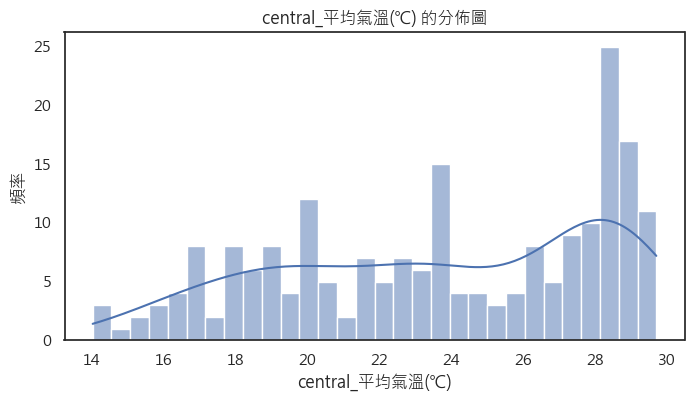

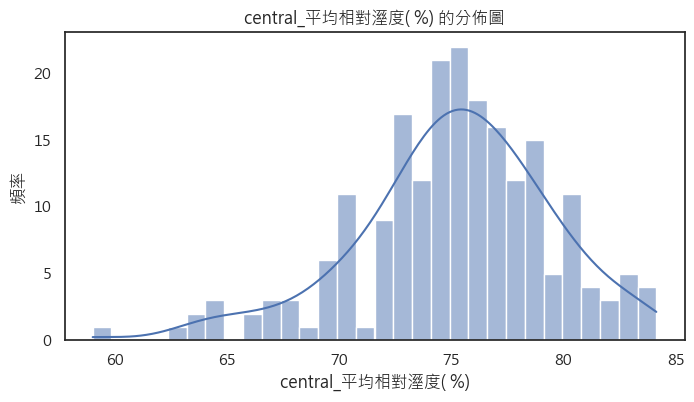

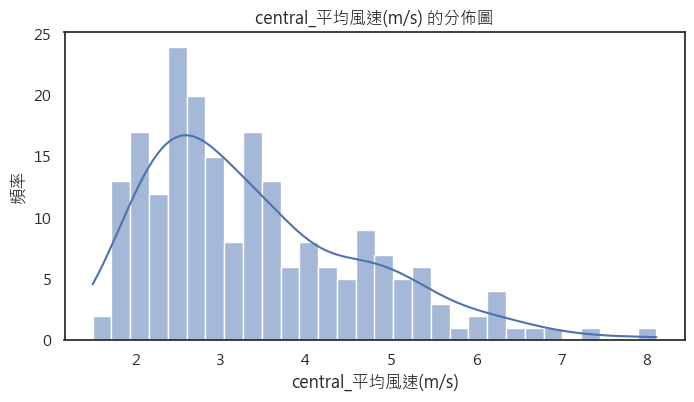

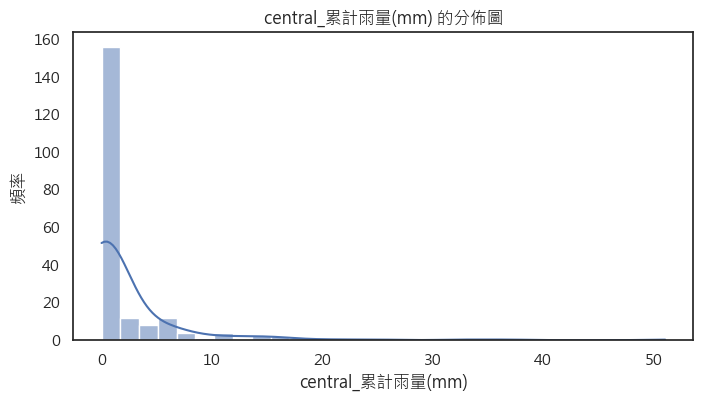

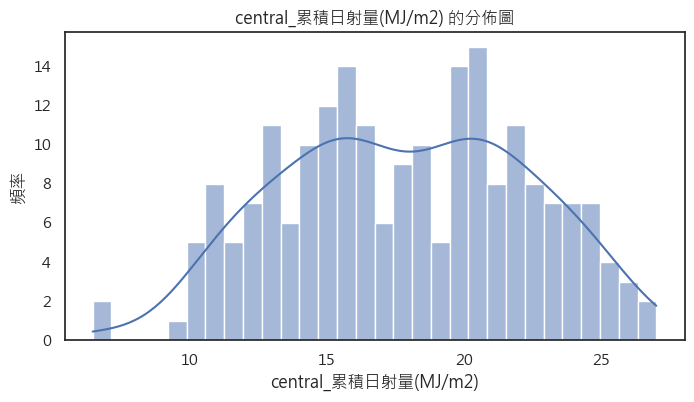

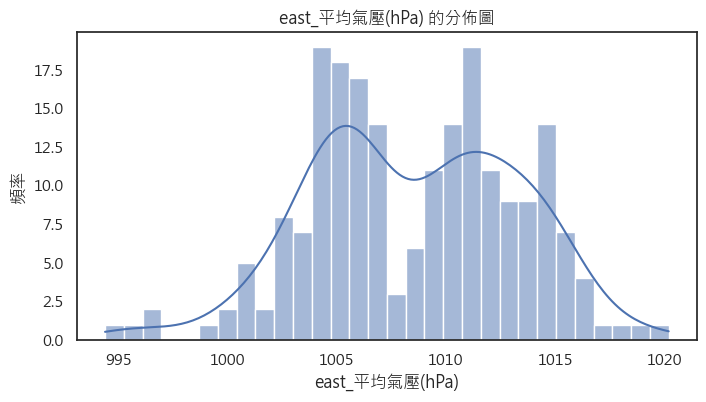

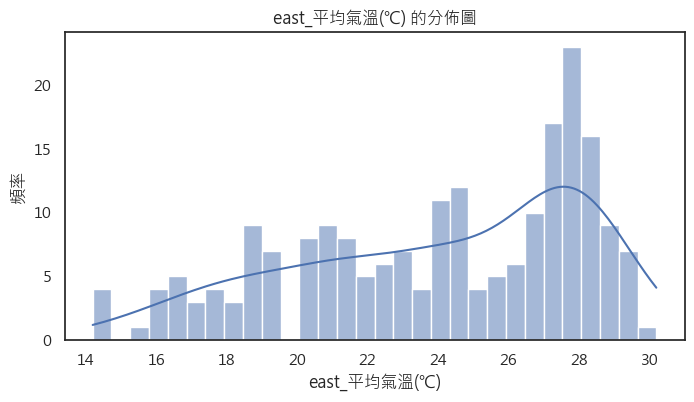

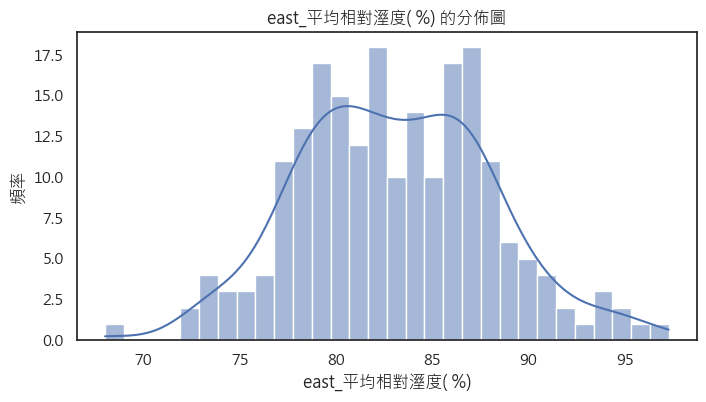

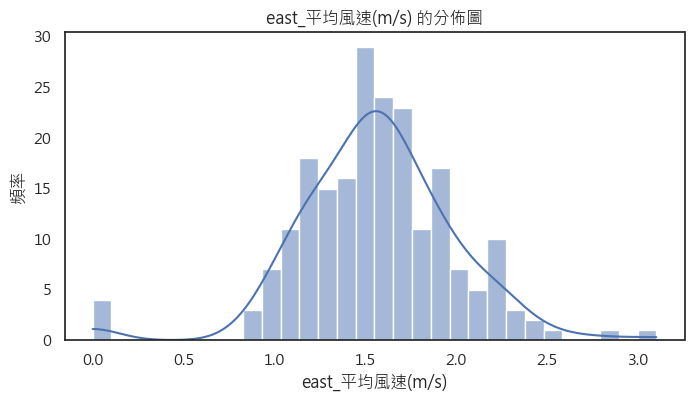

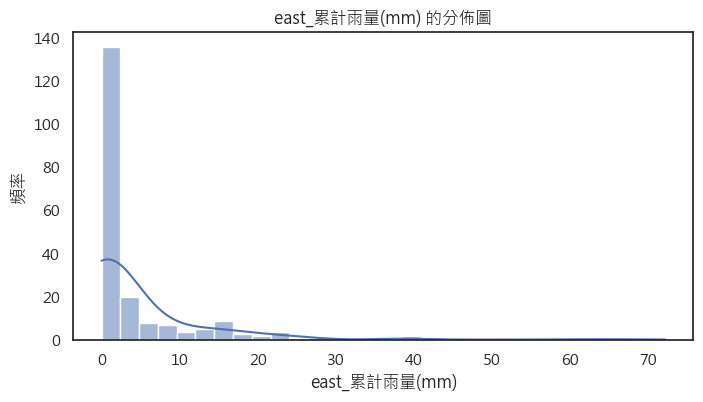

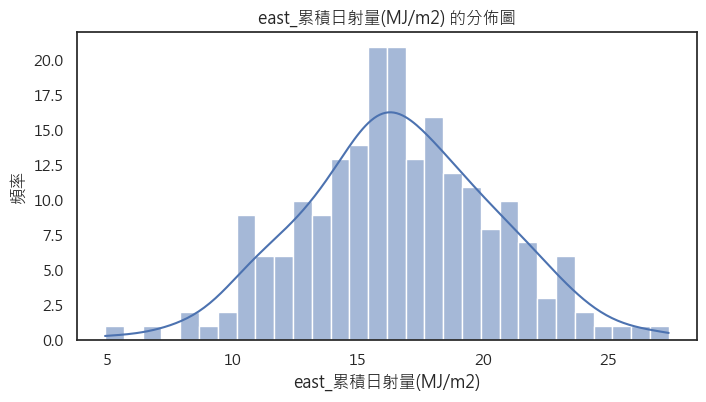

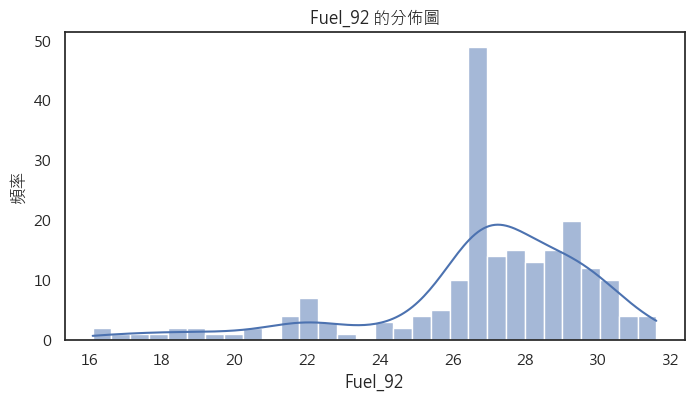

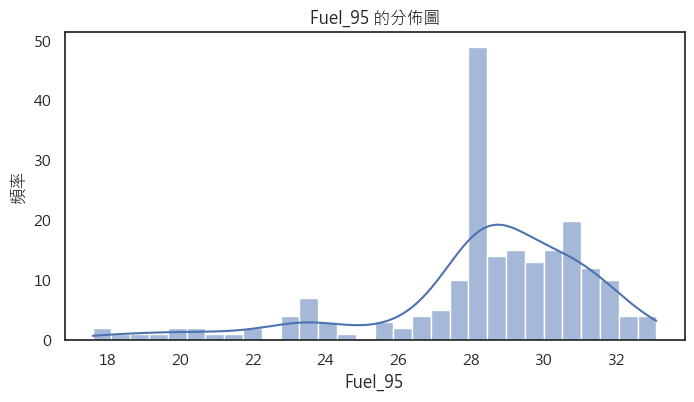

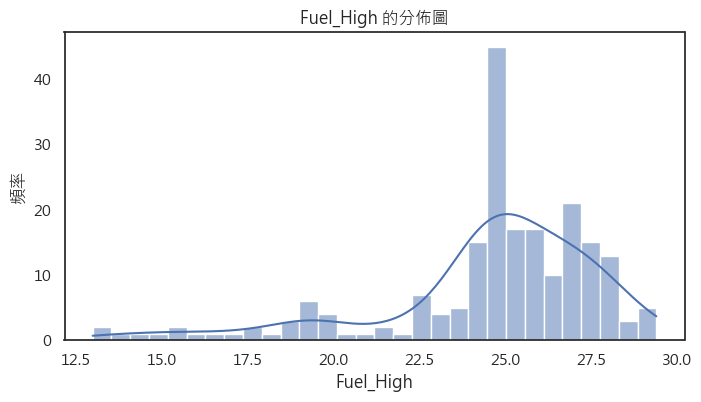

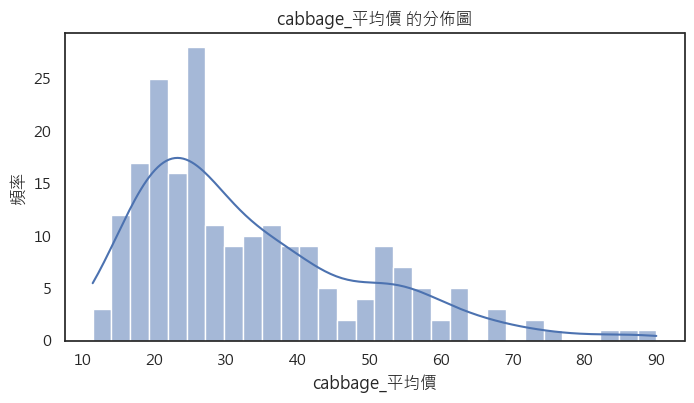

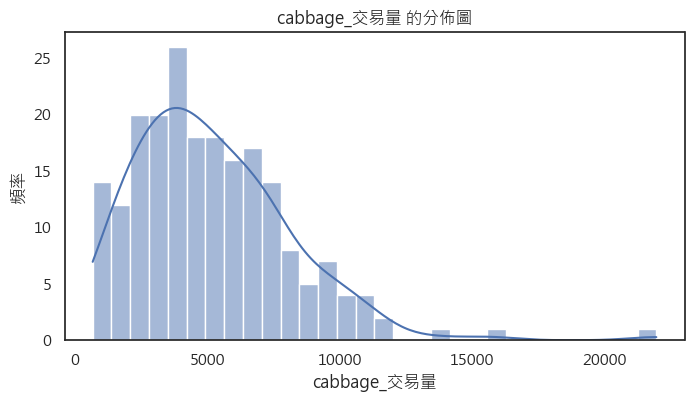

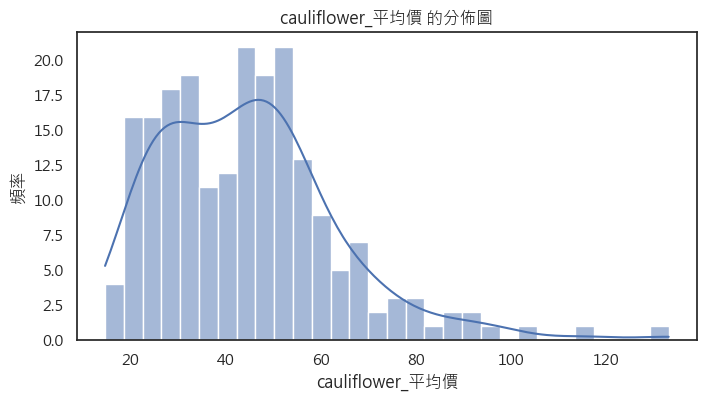

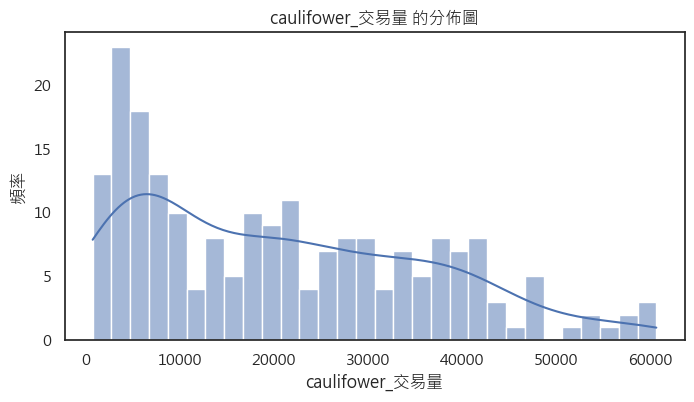

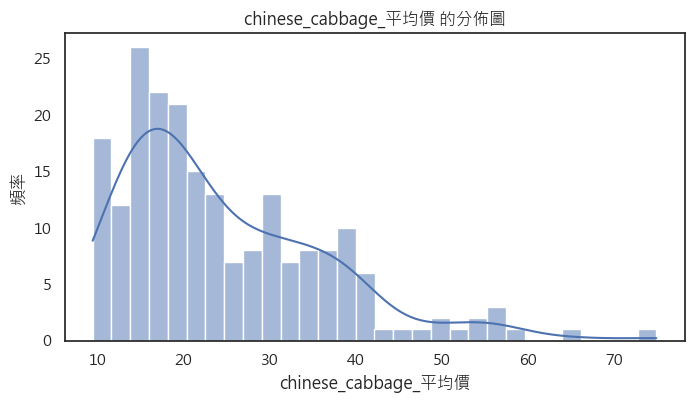

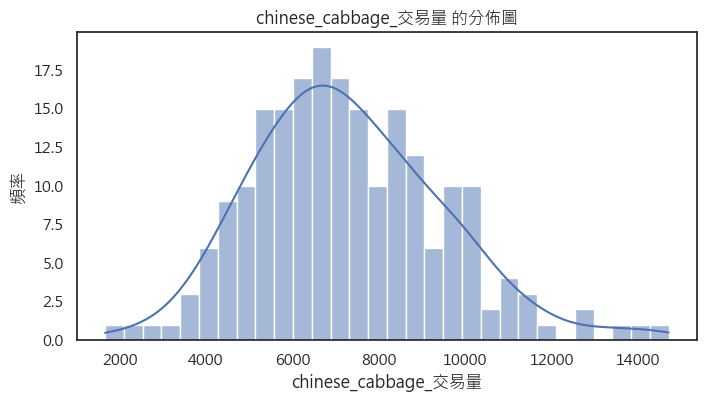

In [13]:
# 數據分佈可視化
for column in data.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'{column} 的分佈圖')
    plt.xlabel(column)
    plt.ylabel('頻率')
    plt.show()

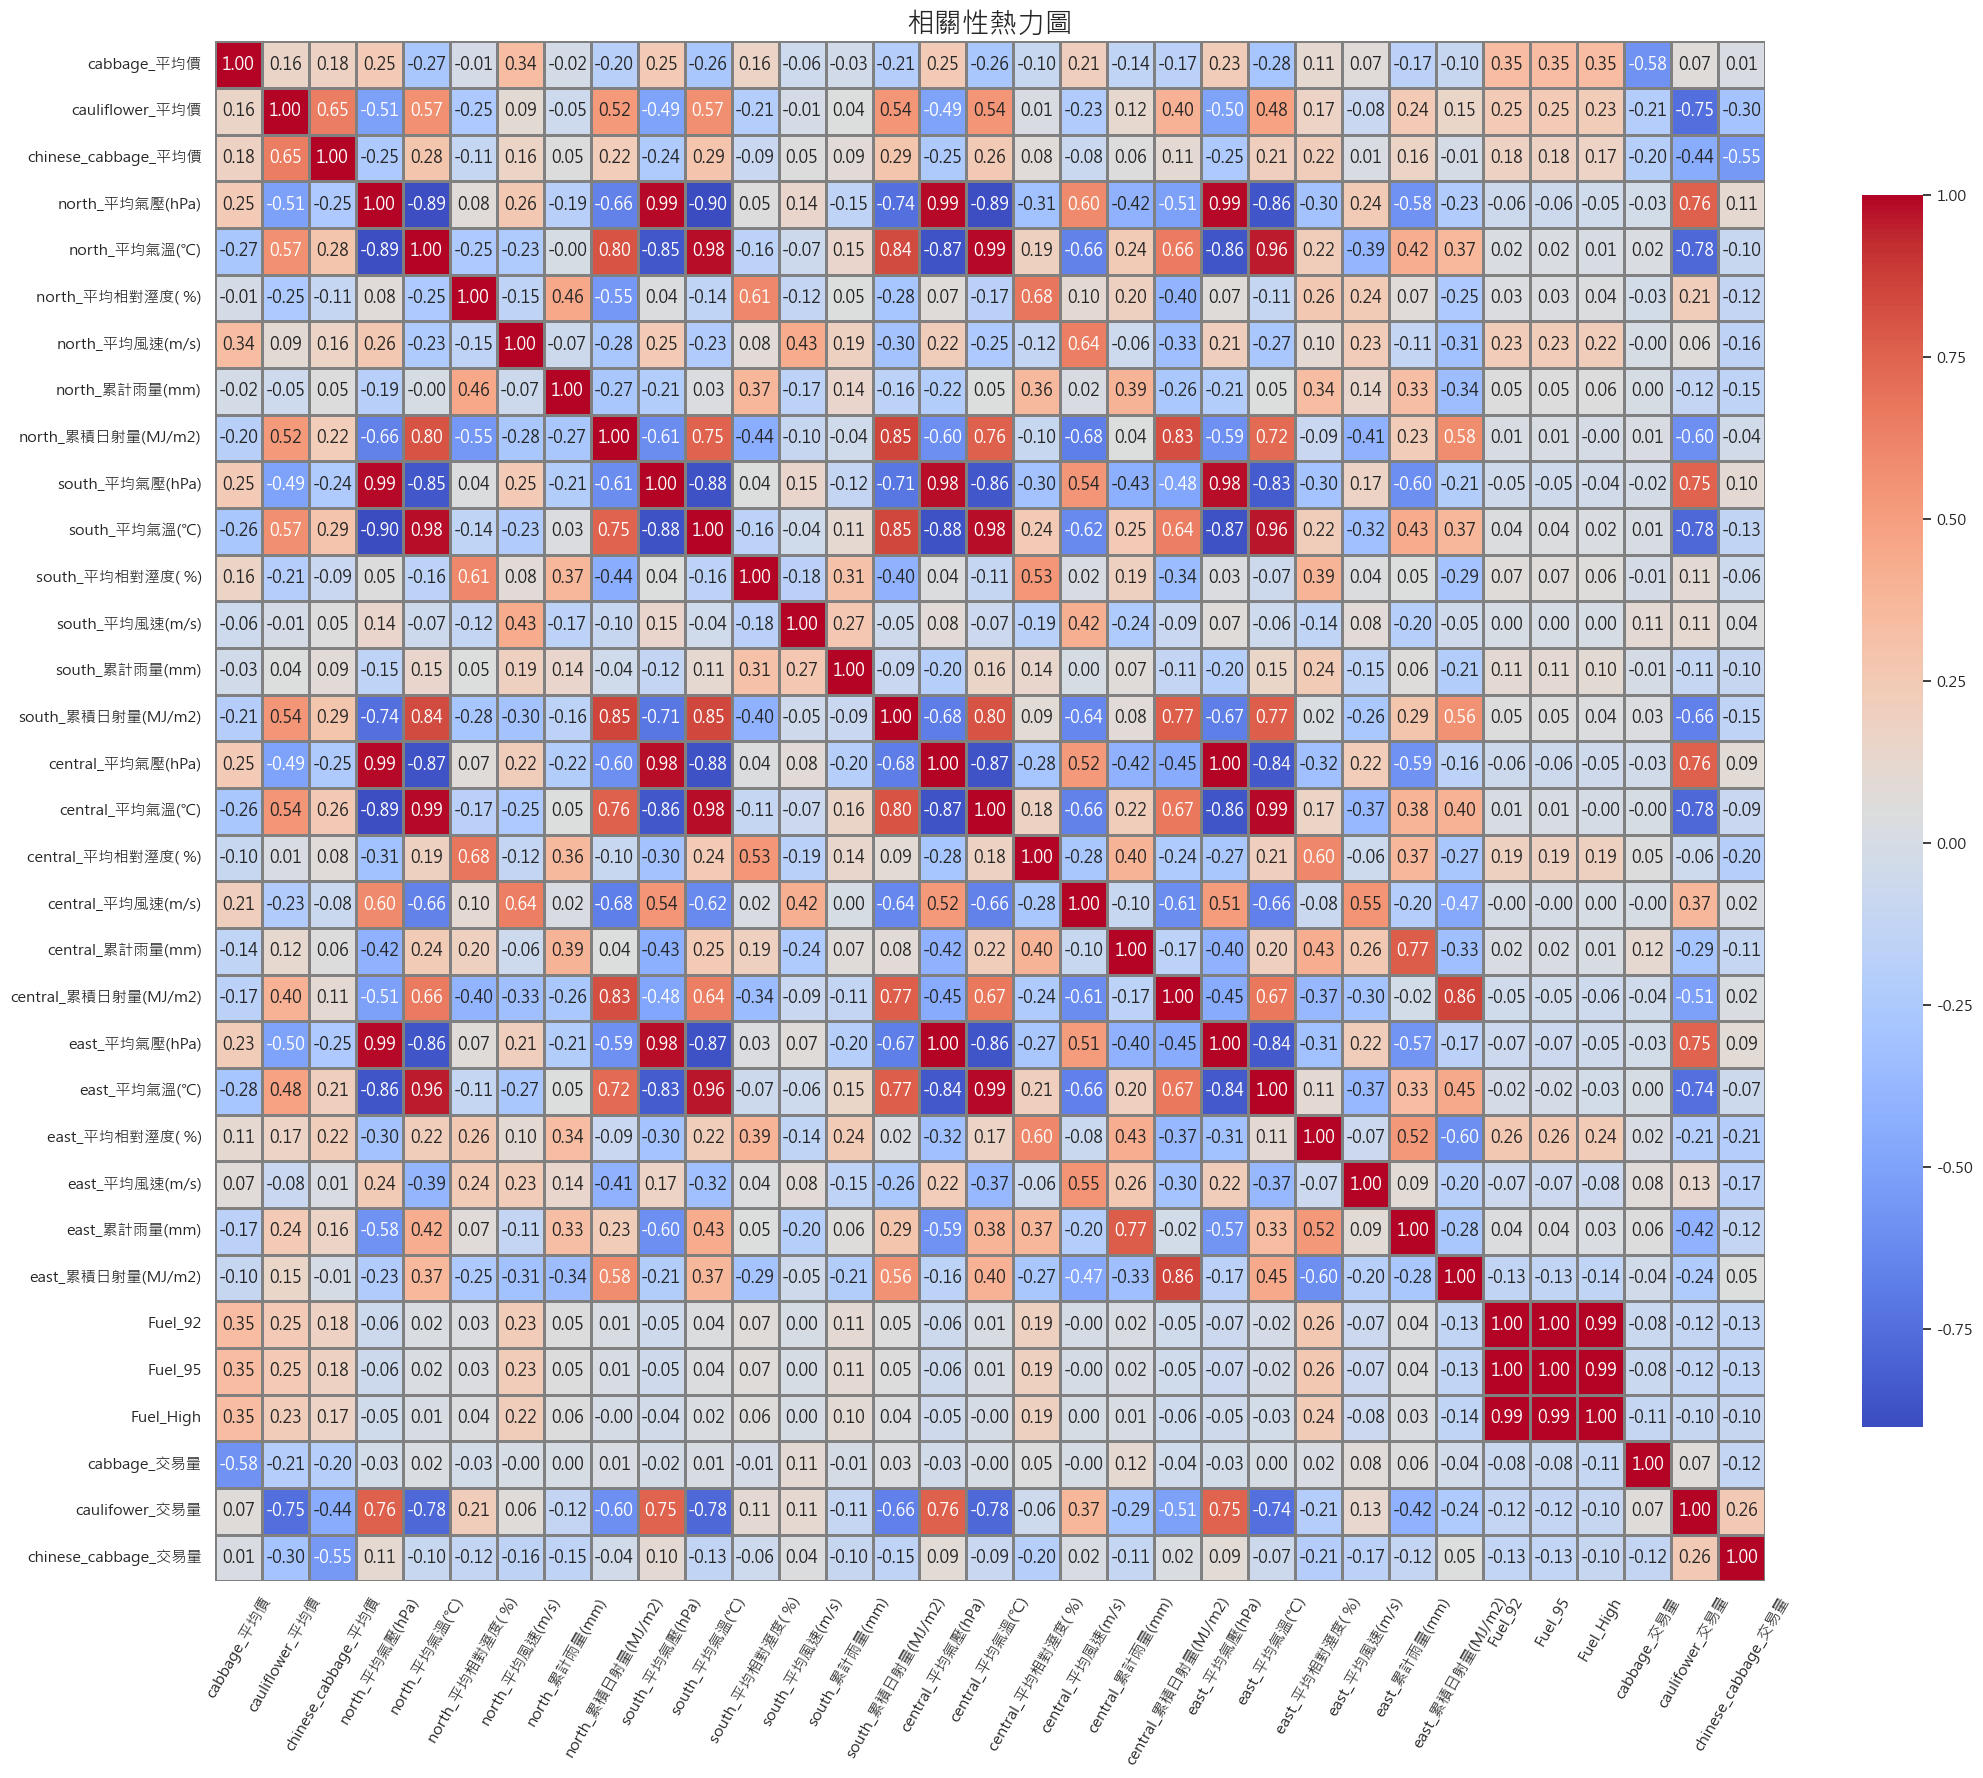

In [29]:
# 篩選出數值型欄位
numeric_data = data.select_dtypes(include=['number'])

# 選取 3 種蔬菜的菜價與其他數值欄位
target_cols = ['cabbage_平均價', 'cauliflower_平均價', 'chinese_cabbage_平均價']
numeric_cols = [col for col in numeric_data.columns if col not in target_cols]

# 合併目標欄位與其他數值欄位
selected_data = numeric_data[target_cols + numeric_cols]

# 計算相關係數矩陣
correlation_matrix = selected_data.corr()

plt.figure(figsize=(25, 20))  # 設定畫布大小
sns.heatmap(
    correlation_matrix,     # 相關性矩陣
    annot=True,             # 在每個方格中顯示數值
    fmt=".2f",              # 顯示數值格式 (小數點後 2 位)
    cmap="coolwarm",        # 配色方案
    linewidths=0.8,         # 格子間隔線
    linecolor='gray',       # 格線顏色
    cbar_kws={'shrink': 0.8}  # 調整 color bar 尺寸
)
plt.title("相關性熱力圖", fontsize=20)  # 添加標題
plt.xticks(rotation=60)  # 調整 x 軸標籤角度
plt.yticks(rotation=0)   # 調整 y 軸標籤角度
plt.show()


# 特徵欄位與3種蔬菜價格相關係數

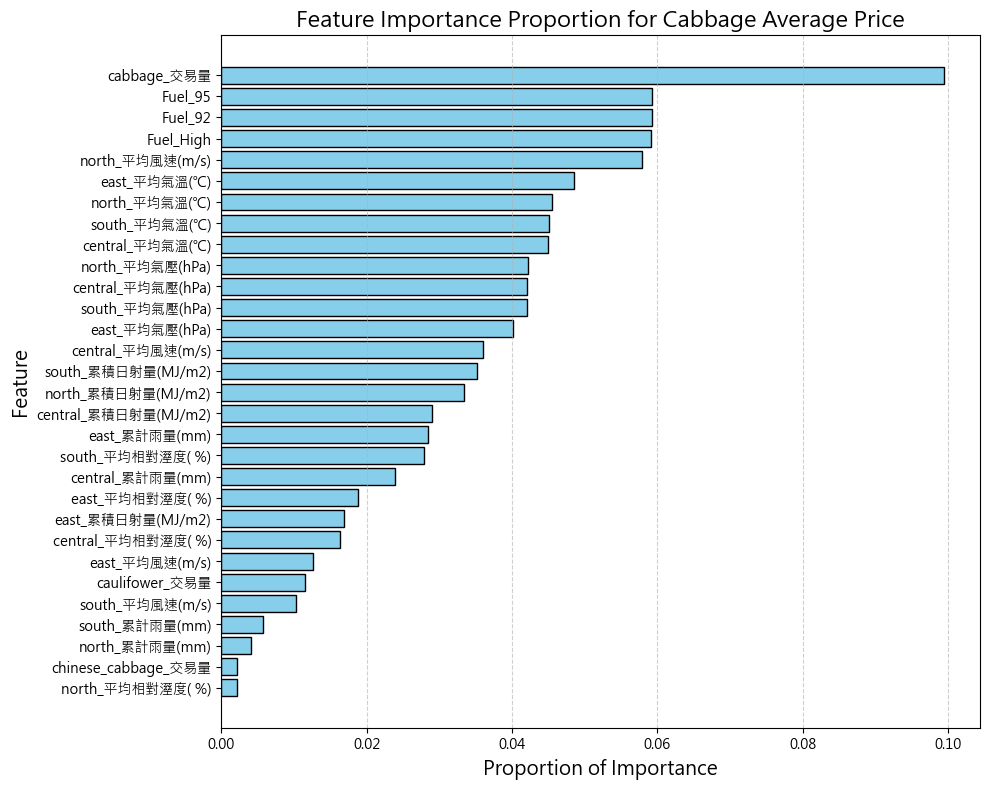

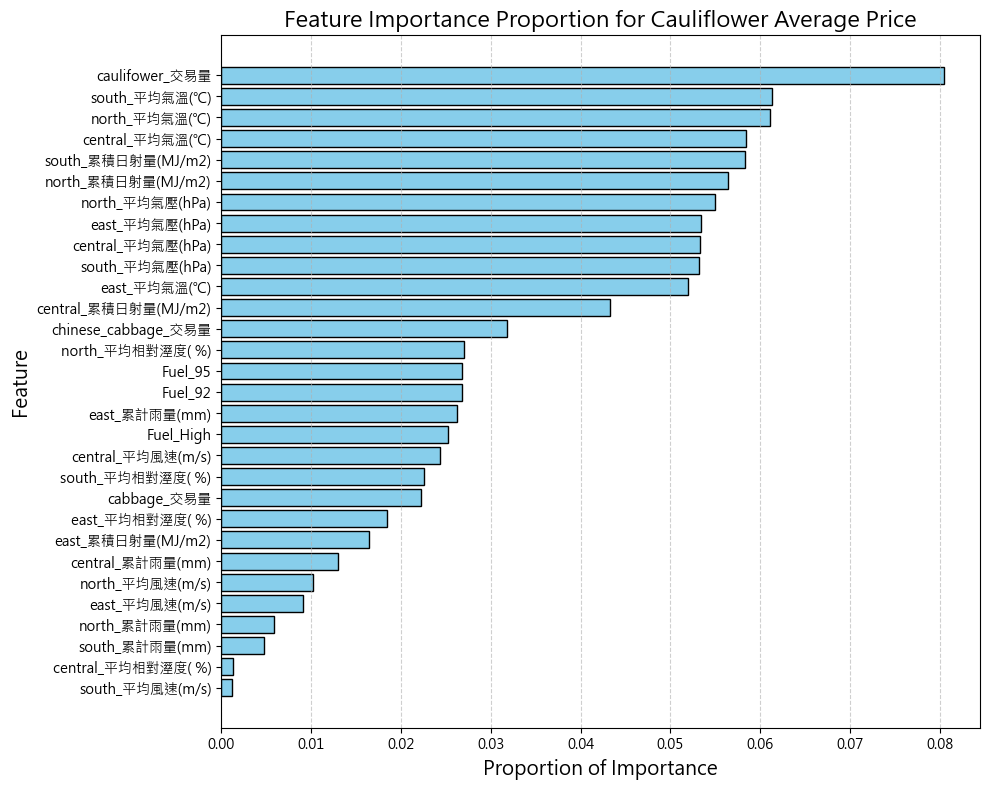

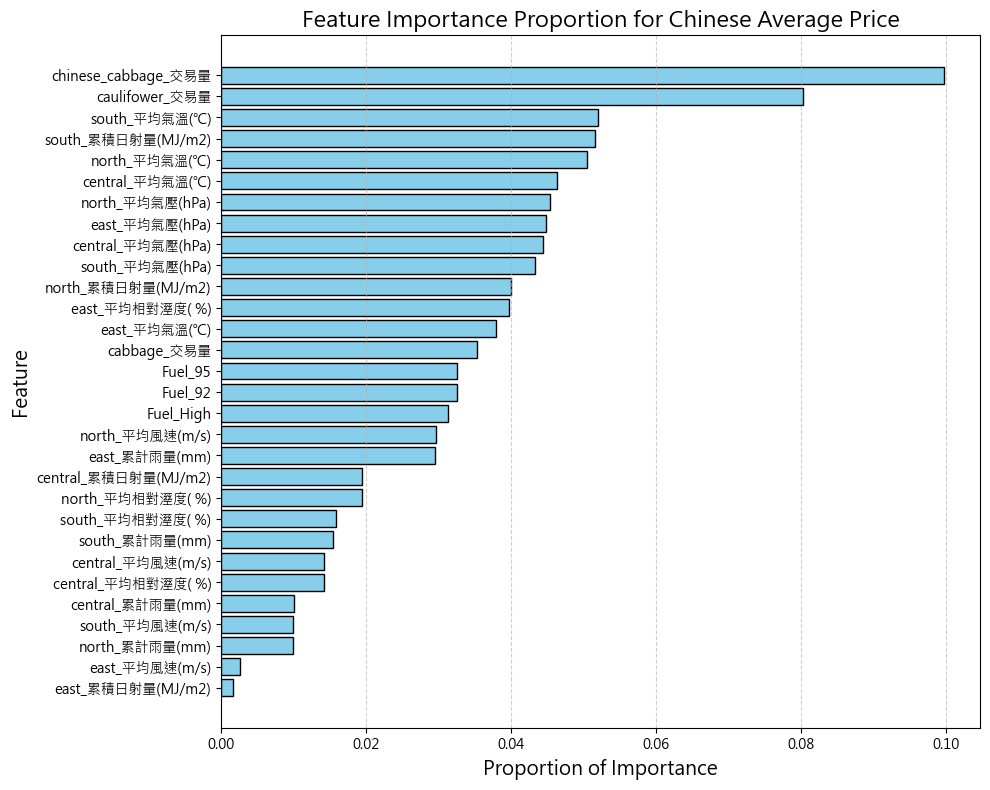

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# 載入資料
file_path = 'All_X_Y.csv'  # 替換為您的檔案路徑
data = pd.read_csv(file_path)

# 目標列
target_columns = ['cabbage_平均價', 'cauliflower_平均價', 'chinese_cabbage_平均價']

# 特徵列：排除目標列並確保只包含數值型欄位
feature_columns = [
    col for col in data.select_dtypes(include=['float64', 'int64']).columns 
    if col not in target_columns
]

# 計算相關係數
correlation_data = data[feature_columns + target_columns].corr()

# 對目標變數計算特徵的相關係數
correlation_cabbage = correlation_data['cabbage_平均價'][feature_columns].abs()
correlation_cauliflower = correlation_data['cauliflower_平均價'][feature_columns].abs()
correlation_chinese_cabbage = correlation_data['chinese_cabbage_平均價'][feature_columns].abs()

# 計算比例 (絕對值歸一化)
cabbage_proportion = correlation_cabbage / correlation_cabbage.sum()
cauliflower_proportion = correlation_cauliflower / correlation_cauliflower.sum()
chinese_cabbage_proportion = correlation_chinese_cabbage / correlation_chinese_cabbage.sum()

# 整理為 DataFrame
importance_data_corr = pd.DataFrame({
    'Feature': feature_columns,
    'Cabbage Proportion': cabbage_proportion.values,
    'Cauliflower Proportion': cauliflower_proportion.values,
    'Chinese Cabbage Proportion': chinese_cabbage_proportion.values
})

# 繪製圖表
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 支援中文字體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

vegetables = ['Cabbage Proportion', 'Cauliflower Proportion', 'Chinese Cabbage Proportion']
for veg in vegetables:
    plt.figure(figsize=(10, 8))
    sorted_data = importance_data_corr.sort_values(by=veg, ascending=False)

    plt.barh(
        sorted_data['Feature'], sorted_data[veg], 
        color='skyblue', edgecolor='black', height=0.8
    )
    plt.title(f"Feature Importance Proportion for {veg.split()[0]} Average Price", fontsize=16)
    plt.xlabel("Proportion of Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.gca().invert_yaxis()  # 反轉 y 軸
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



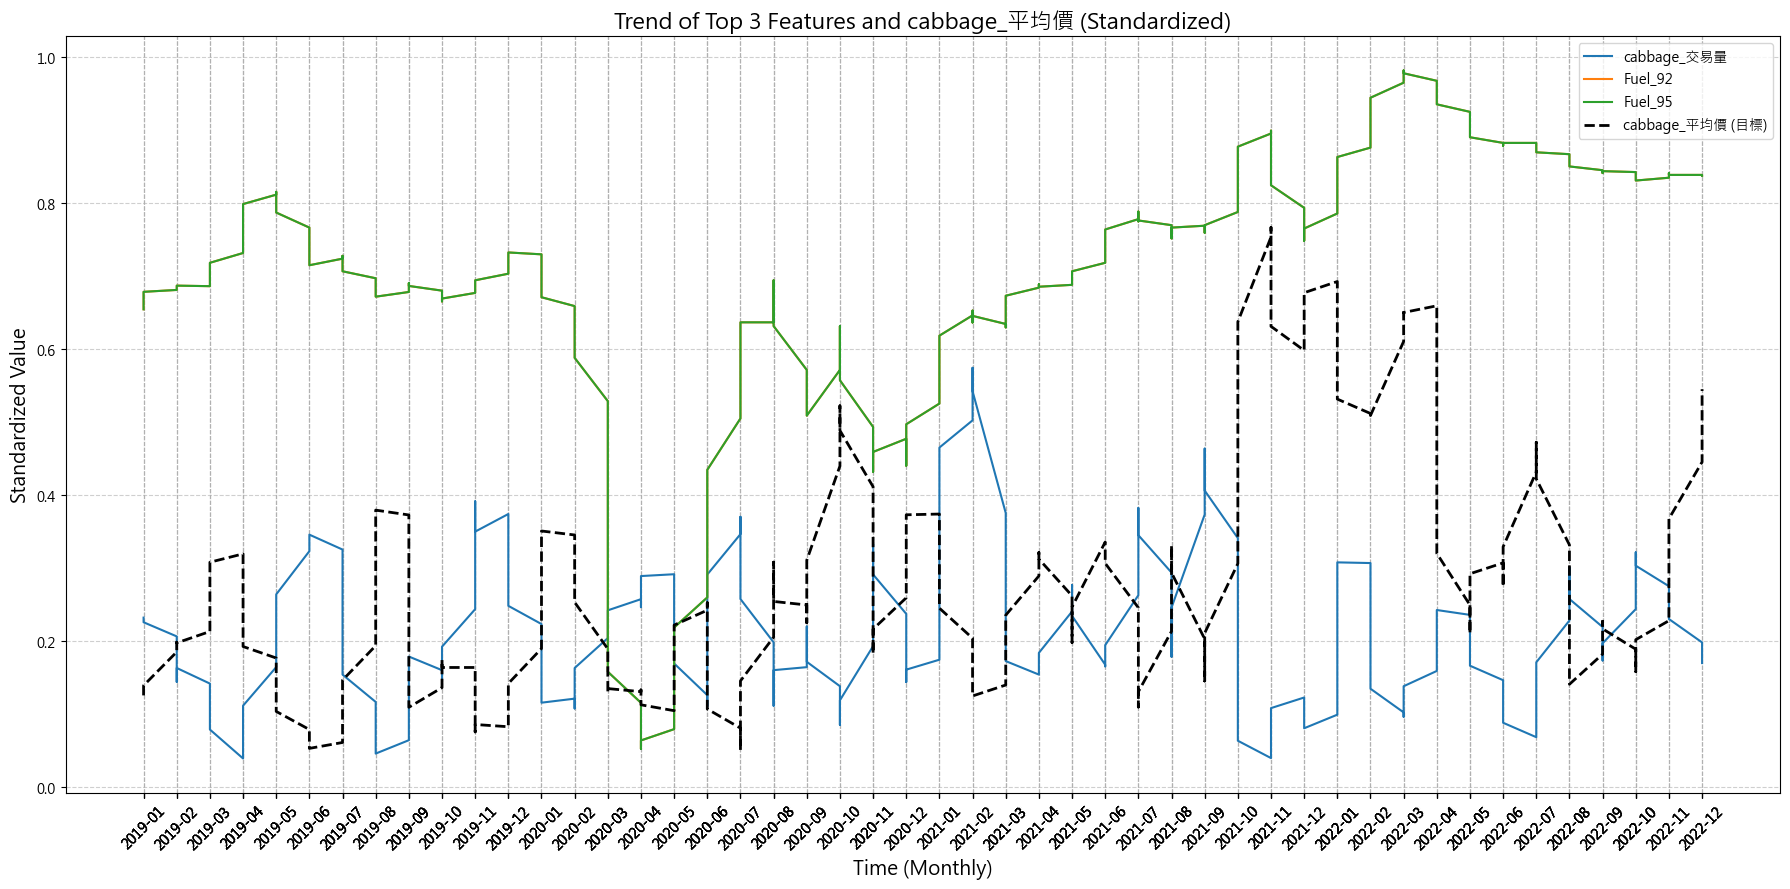

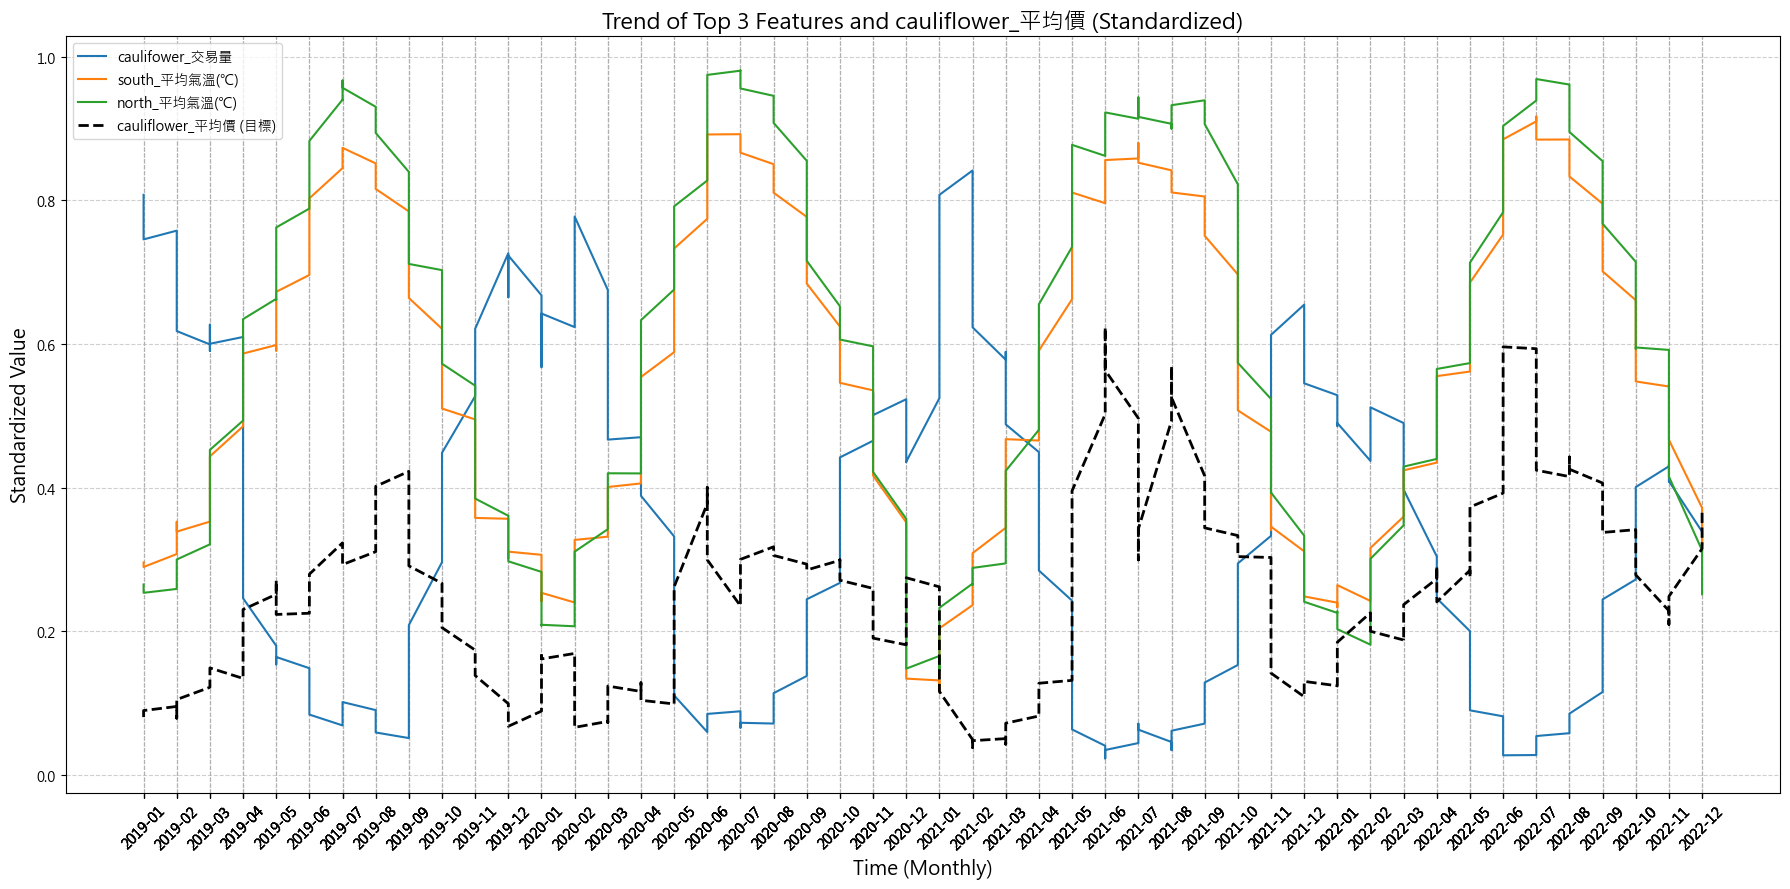

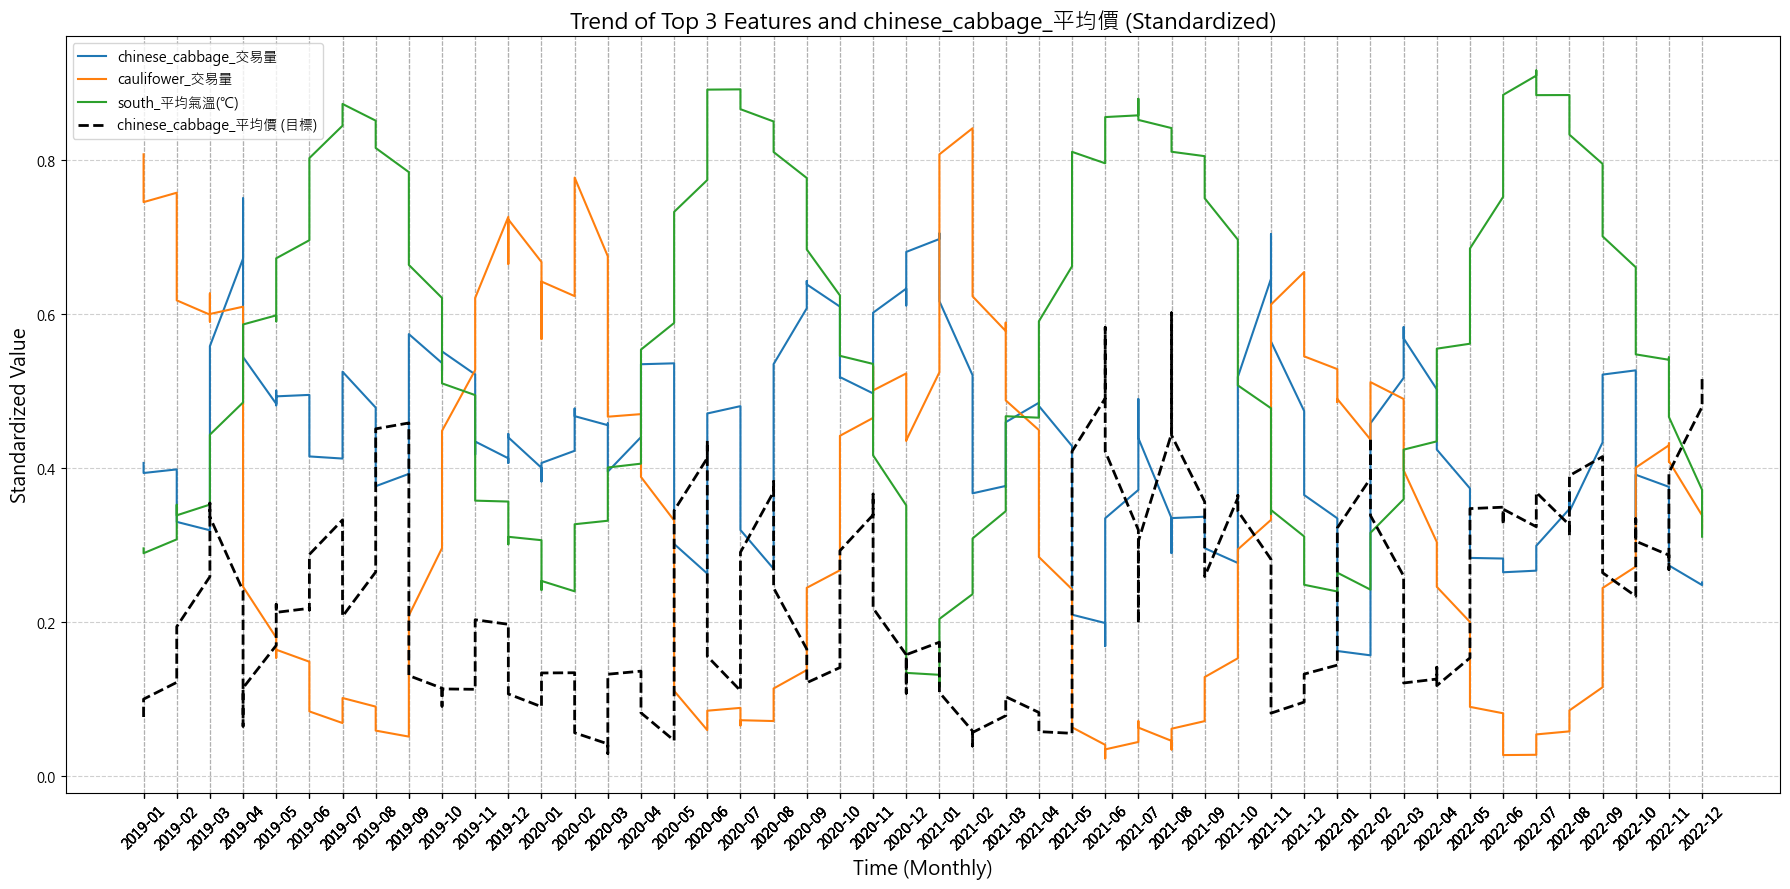

In [53]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

# 載入資料
file_path = 'All_X_Y.csv'  # 替換為您的檔案路徑
data = pd.read_csv(file_path)

# 時間欄位
time_column = 'date'  # 替換為資料中的實際時間欄位名稱

# 提取範圍的起始日期
data[time_column] = data[time_column].str.split('/').str[0]  # 提取範圍的起始日期
data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d')  # 轉換為日期格式

# 目標列
target_columns = ['cabbage_平均價', 'cauliflower_平均價', 'chinese_cabbage_平均價']

# 特徵列：排除目標列和時間欄位，確保只包含數值型欄位
feature_columns = [
    col for col in data.select_dtypes(include=['float64', 'int64']).columns 
    if col not in target_columns
]

# 數值型數據
numeric_data = data[feature_columns + target_columns]

# 使用 MinMaxScaler 對數值型欄位進行標準化
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(numeric_data), columns=numeric_data.columns)
data_normalized[time_column] = data[time_column]  # 將時間欄位加入標準化後的數據

# 計算相關係數
correlation_data = numeric_data.corr()

# 對目標變數計算特徵的相關係數 (取絕對值)
correlation_cabbage = correlation_data['cabbage_平均價'][feature_columns].abs()
correlation_cauliflower = correlation_data['cauliflower_平均價'][feature_columns].abs()
correlation_chinese_cabbage = correlation_data['chinese_cabbage_平均價'][feature_columns].abs()

# 找出前三高相關特徵
top_features_cabbage = correlation_cabbage.nlargest(3).index.tolist()
top_features_cauliflower = correlation_cauliflower.nlargest(3).index.tolist()
top_features_chinese_cabbage = correlation_chinese_cabbage.nlargest(3).index.tolist()

# 滾動平均平滑曲線
def smooth_series(series, window_size=5):
    return series.rolling(window=window_size, center=True).mean()

# 繪製趨勢圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 支援中文字體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

for target, top_features in zip(
    target_columns, 
    [top_features_cabbage, top_features_cauliflower, top_features_chinese_cabbage]
):
    plt.figure(figsize=(12, 6))
    for feature in top_features:
        plt.plot(
            data_normalized[time_column], 
            smooth_series(data_normalized[feature]), 
            label=f"{feature}"
        )
    plt.plot(
        data_normalized[time_column], 
        smooth_series(data_normalized[target]), 
        label=f"{target} (目標)", linestyle='--', linewidth=2, color='black'
    )
    plt.title(f"Trend of Top 3 Features and {target} (Standardized)", fontsize=16)
    plt.xlabel("Time (Weekly)", fontsize=14)
    plt.ylabel("Standardized Value", fontsize=14)
    plt.xticks(data_normalized[time_column][::4], rotation=45)  # 每 4 週標示一次日期
    plt.legend()
    plt.grid(linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# 蔬菜價格每周變化趨勢圖

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定義日期解析函數，提取日期範圍中的起始日期
def extract_start_date(date_range):
    return pd.to_datetime(date_range.split('/')[0])


# 加載數據
train_file_path = 'All_X_Y.csv'
train_data = pd.read_csv(train_file_path)

# 提取每周的起始日期
train_data['start_date'] = train_data['date'].apply(extract_start_date)

# 添加月份標籤
train_data['month'] = train_data['start_date'].dt.to_period('M')



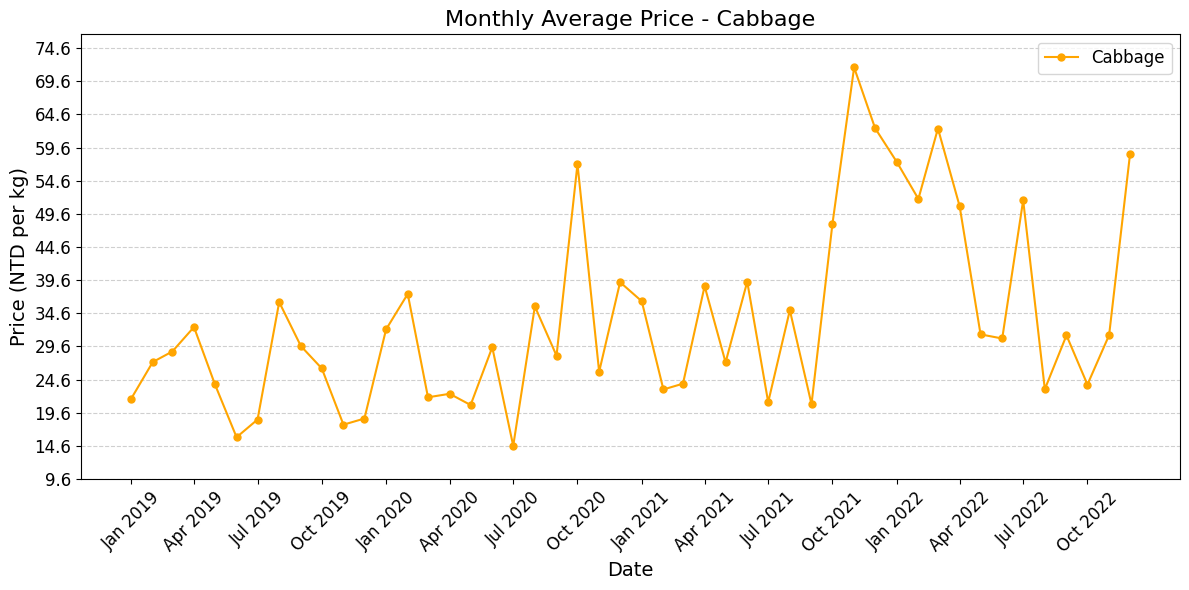

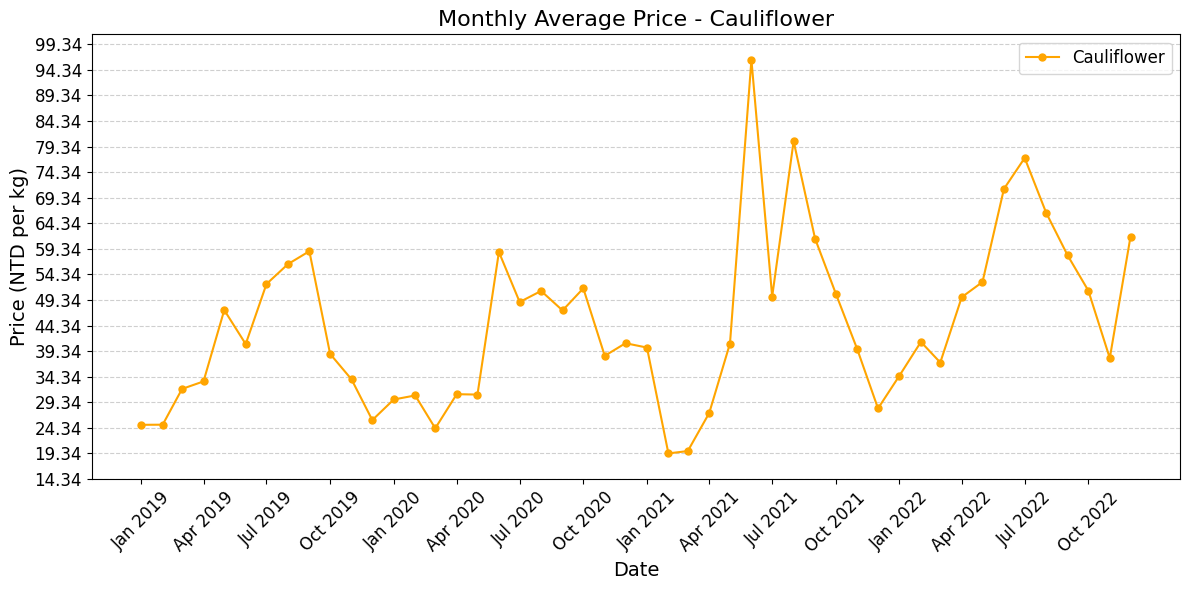

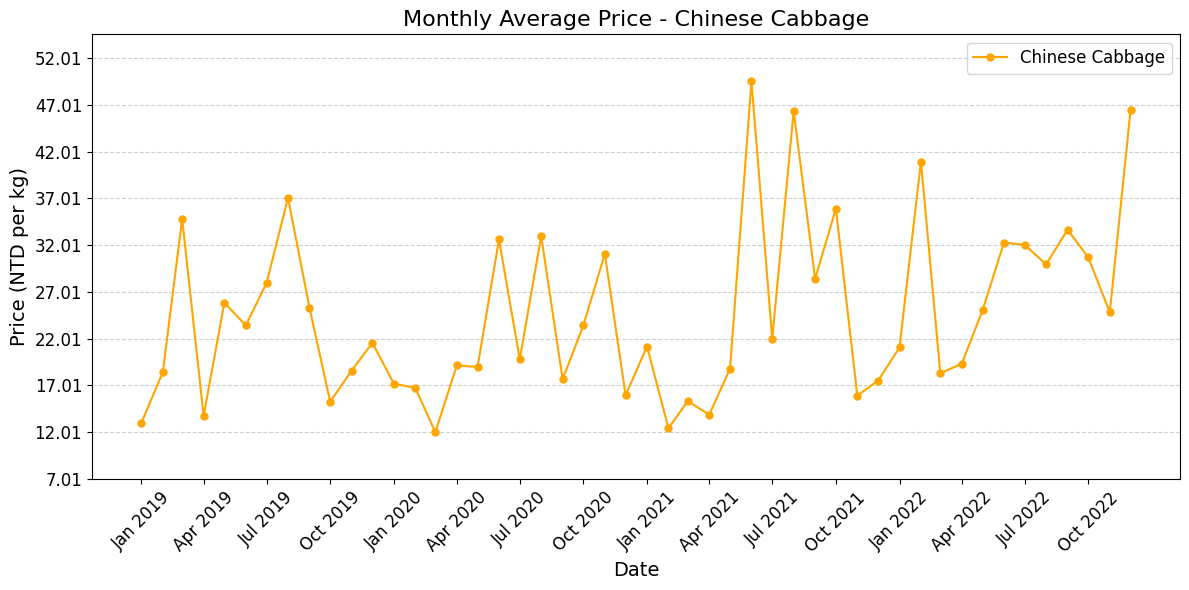

In [35]:

# 定義蔬菜價格的欄位名稱和標籤
vegetables = {
    'cabbage_平均價': 'Cabbage',
    'cauliflower_平均價': 'Cauliflower',
    'chinese_cabbage_平均價': 'Chinese Cabbage'
}

# 繪圖
for veg_col, veg_label in vegetables.items():
    # 按月份計算平均值
    monthly_data = train_data.groupby('month')[veg_col].mean().reset_index()
    monthly_data['start_date'] = monthly_data['month'].dt.to_timestamp()  # 將月份轉為時間戳
    
    plt.figure(figsize=(12, 6))
    plt.plot(
        monthly_data['start_date'],
        monthly_data[veg_col],  # 每月平均數據
        marker='o',
        markersize=5,  # 減少標記大小
        label=f'{veg_label}',
        color='orange'
    )
    plt.title(f"Monthly Average Price - {veg_label}", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Price (NTD per kg)", fontsize=14)
    
    # 計算 Y 軸範圍並調整
    min_price = monthly_data[veg_col].min()
    max_price = monthly_data[veg_col].max()
    y_min = max(0, min_price - 5)  # 最小值不低於 0
    y_max = max_price + 5
    plt.ylim(y_min, y_max)  # Y 軸範圍
    plt.yticks(np.arange(y_min, y_max + 1, 5), fontsize=12)  # 每 5 單位設置一個刻度，整數顯示
    
    # 調整 X 軸標籤顯示為月份
    plt.xticks(
        monthly_data['start_date'][::3],  # 每隔 3 個月顯示一個標籤
        labels=[date.strftime("%b %Y") for date in monthly_data['start_date'][::3]],  # 顯示月份和年份
        rotation=45,
        fontsize=12
    )
    
    # 簡化網格線
    plt.grid(axis='y', linestyle='--', alpha=0.6)  # 僅顯示水平網格線
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
